In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import trange
import torch
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# Read the data
train = pd.read_csv('memes_train.csv')
test = pd.read_csv('memes_test.csv')
print('training dataset: ', train.shape)
print('testing dataset: ', test.shape)

training dataset:  (6625, 10)
testing dataset:  (1657, 10)


In [4]:
# use cuda if available
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
## install detectron2
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [6]:
from transformers import LayoutLMv2Processor, LayoutLMv2Model, set_seed
from PIL import Image
import pytesseract

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased")
model = LayoutLMv2Model.from_pretrained("microsoft/layoutlmv2-base-uncased").to(device)

image_path = "images/Cnmi68uWEAAmxD6.jpg"
image = Image.open(image_path).convert("RGB")
text = "When is coffee break?"

encoding = processor(image, text, return_tensors="pt").to(device)

outputs = model(**encoding)
last_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at microsoft/layoutlmv2-base-uncased were not used when initializing LayoutLMv2Model: ['layoutlmv2.visual.backbone.bottom_up.res4.11.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.2.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.18.conv1.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.12.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res2.2.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.13.conv2.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.3.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.4.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res4.8.conv3.norm.num_batches_tracked', 'layoutlmv2.visual.backbone.bottom_up.res3.2.conv3.norm.num_batches_tracked', 'layoutlmv2.v

In [7]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [8]:
# define the classifier
model = model.to(device)
LayoutLM_embed_dim = 768  # final embedding dimension of LayoutLM
n_classes = 2        # number of classes for my dataset
classifier = nn.Linear(LayoutLM_embed_dim, n_classes)

In [9]:
# prepare the dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import requests

class MemeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # read the data from the dataframe
        row = self.df.iloc[idx]
        image = row['image_path']
        # image = Image.open(image).convert('RGB')
        if self.transform:
            image = Image.open(image).convert('RGB')
            image = self.transform(image)        
        text = str(row['image_text'])
        # date = row['created_at']
        label = row['label']

        return image, text, label

# define transforms
transform = {
        'train' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(50),
                                      transforms.ToTensor()]),

        'valid' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
        }


In [10]:
# splite the training set into train and valid
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)
# get 2000 samples for training, 500 for validation
random_state = 21
train_df = train_df.sample(n=1000, random_state=random_state)
valid_df = valid_df.sample(n=300, random_state=random_state)

print('training dataset: ', train_df.shape)
print('validation dataset: ', valid_df.shape)

training dataset:  (1000, 10)
validation dataset:  (300, 10)


In [11]:
# load the dataset
train_dataset = MemeDataset(train_df)
valid_dataset = MemeDataset(valid_df)
test_dataset = MemeDataset(test)

In [12]:
# define the dataloader
batch_size = 10
num_workers = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=20, num_workers=num_workers, shuffle=False)

In [13]:
# define the fine-tune function
def fine_tune_LayoutLM(model,     # the model to fine-tune
                  classifier,  # single-layer fully-connected classifier
                  dataloaders, # dict with 2 keys, "train" and "valid", containing train & valid dataloaders
                  n_epochs,    # number of epochs to fine-tune
                  lr,          # learning rate
                  multi_label_data=False
                  ):
  
  model.to(device)
  classifier.to(device)

  #  1. Define optimizers and loss function  
  optimizer_encoder = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.9))
  optimizer_classifier = optim.Adam(classifier.parameters(), lr=lr, betas=(0.5, 0.9))
  ### Different loss criterion for multi-label and single-label data
  if multi_label_data:
    criterion = nn.BCEWithLogitsLoss().to(device)
  else: # single-label data (standard)
    criterion = nn.CrossEntropyLoss().to(device)
  
  train_losses, val_losses, val_accs = [], [], []
  for e in trange(n_epochs, desc="Epoch"):
    #  2. Train on training data  
    model.train()
    classifier.train()
    train_loss = 0.
    for batch_i, (image, text, label) in enumerate(train_loader):
      # image = Image.open(requests.get(img, stream=True).raw)
      # image = Image.open(img)
      images = []
      for img in image:
        images.append(Image.open(img).convert('RGB'))
      # texts = []
      # for txt in text:
      #   texts.append(txt)
      inputs = processor(images, text, return_tensors="pt", padding=True, truncation=True).to(device)
      outputs = model(**inputs)
      logits = classifier(outputs.pooler_output) #get the predictions 
           
      optimizer_encoder.zero_grad()
      optimizer_classifier.zero_grad()

      label = label.to(device)
      if multi_label_data:
        loss = criterion(logits.type(torch.FloatTensor), label.type(torch.FloatTensor))
      else:
        loss = criterion(logits.squeeze(-1).to(device), label)

      loss.backward()
      optimizer_encoder.step()
      optimizer_classifier.step()
      train_loss += loss.item()
      print(f"For batch {batch_i+1}/{len(train_loader)}.. "
            f"Train loss: {loss.item():.3f}.. ")
    train_losses.append(train_loss/len(train_loader))
    print(f"Epoch {e+1}/{n_epochs}.. "
          f"Train loss: {train_loss/len(train_loader):.3f}.. ") 
    # clean the cache
    # torch.cuda.empty_cache()

    #  3. Evaluate on valdiation data  
    model.eval()
    classifier.eval()
    val_loss = 0.
    for batch_i, (val_image, val_text, val_label) in enumerate(valid_loader):
      # image = Image.open(img)
      val_images = []
      for img in val_image:
        val_images.append(Image.open(img).convert('RGB'))
      # texts = []
      # for txt in text:
      #   texts.append(txt)
      inputs = processor(val_images, val_text, return_tensors="pt", padding=True, truncation=True).to(device)
      val_label = val_label.to(device)
      with torch.no_grad():
        outputs = model(**inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # loss = criterion(logits.type(torch.FloatTensor), label.type(torch.FloatTensor))
        loss = criterion(logits.squeeze(-1).to(device), val_label)
        val_loss += loss.item()
    
    #  4. Log results and save model checkpoints 
    print("Epoch: {}/{}   Val CE Loss: {:.5f}".format(e+1, n_epochs, val_loss/len(valid_loader)))
    val_losses.append(val_loss/len(valid_loader))
    # # save the best model
    if val_loss/len(valid_loader) < min(val_losses):
      torch.save(model.state_dict(), 'models/layoutlm_best_encoder.pt')
      torch.save(classifier.state_dict(), 'models/layoutlm_best_classifier.pt')
    

    # save the checkpoint
    torch.save({
            'epoch': e+1,
            'encoder_state_dict': model.state_dict(),
            'classifier_state_dict': classifier.state_dict(),
            'optimizer_encoder_state_dict': optimizer_encoder.state_dict(),
            'optimizer_classifier_state_dict': optimizer_classifier.state_dict(),
            'loss': loss,
            }, 'models/layoutlm.pt')

  return model, classifier

In [14]:
# # load the checkpoint
# checkpoint = torch.load('models/layoutlm.pt')
# model.load_state_dict(checkpoint['encoder_state_dict'])
# classifier.load_state_dict(checkpoint['classifier_state_dict'])
# classifier = classifier.to(device)

In [ ]:
# fine-tune the model
model, classifier = fine_tune_LayoutLM(model, 
                                    classifier, 
                                    n_epochs=5, 
                                    lr=3e-6,
                                    dataloaders={'train': train_loader, 'valid': valid_loader}
                                    )

In [ ]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

tp, fp, tn, fn = 0, 0, 0, 0
y_true = []
y_pred = []

model.eval()
classifier.eval()
test_loss = 0.

for batch_i, (test_image, test_text, test_label) in enumerate(test_loader):
    # image = Image.open(img)
    test_images = []
    for img in test_image:
        test_images.append(Image.open(img).convert('RGB'))
    inputs = processor(test_images, test_text, return_tensors="pt", padding=True, truncation=True).to(device)
    test_label = test_label.to(device)
    with torch.no_grad():
        # embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        outputs = model(**inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # generate predictions
        probs = torch.sigmoid(logits)
        scores = probs[:,1]
        preds = torch.argmax(logits, dim=1)
        # print(preds)
        # print(test_label)
        print('The number of correct predictions: ', (preds == test_label).sum().item(), '/', len(preds))
        # break
        
    # get the accuracy
    for i in range(len(preds)):
        if preds[i] == 1 and test_label[i] == 1:
            tp += 1
        elif preds[i] == 0 and test_label[i] == 0:
            tn += 1
        elif preds[i] == 1 and test_label[i] == 0:
            fp += 1
        else:
            fn += 1   
    
    for i in range(len(scores)):
        y_true.append(test_label[i].item())
        y_pred.append(scores[i].item())

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

The number of correct predictions:  9 / 20
The number of correct predictions:  12 / 20
The number of correct predictions:  10 / 20
The number of correct predictions:  9 / 20
The number of correct predictions:  13 / 20
The number of correct predictions:  12 / 20
The number of correct predictions:  13 / 20
The number of correct predictions:  10 / 20
The number of correct predictions:  9 / 20
The number of correct predictions:  13 / 20
The number of correct predictions:  10 / 20
The number of correct predictions:  12 / 20
The number of correct predictions:  12 / 20
The number of correct predictions:  13 / 20
The number of correct predictions:  7 / 20
The number of correct predictions:  13 / 20
The number of correct predictions:  14 / 20
The number of correct predictions:  11 / 20
The number of correct predictions:  14 / 20
The number of correct predictions:  14 / 20
The number of correct predictions:  9 / 20
The number of correct predictions:  12 / 20
The number of correct predictions:  1

In [ ]:
# save the results
import pandas as pd
df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
df.to_csv('results/layoutlm_roc.csv', index=False)
df = pd.DataFrame({'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}, index=[0])
df.to_csv('results/layoutlm_cm.csv', index=False)

In [3]:
df_cm = pd.read_csv('results/layoutlm_cm.csv')

In [4]:
tp = df_cm['tp'][0]
fp = df_cm['fp'][0]
tn = df_cm['tn'][0]
fn = df_cm['fn'][0]

In [5]:
# print the evaluation metrics in a table
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Metric", "Value"]
x.add_row(["Accuracy", (tp+tn)/(tp+tn+fp+fn)])
x.add_row(["Precision", tp/(tp+fp)])
x.add_row(["Recall", tp/(tp+fn)])
x.add_row(["F1 Score", 2*tp/(2*tp+fp+fn)])
print(x)

+-----------+--------------------+
|   Metric  |       Value        |
+-----------+--------------------+
|  Accuracy | 0.6228123114061557 |
| Precision | 0.5541284403669725 |
|   Recall  | 0.8129205921938089 |
|  F1 Score | 0.6590289143480633 |
+-----------+--------------------+


In [3]:
df_layout = pd.read_csv('results/layoutlm_roc.csv')
df_vilt = pd.read_csv('results/vilt_roc.csv')

In [4]:
# get the lists of fpr, tpr, thresholds
fpr_layout = df_layout['fpr'].tolist()
tpr_layout = df_layout['tpr'].tolist()
thresholds_layout = df_layout['thresholds'].tolist()

fpr_vilt = df_vilt['fpr'].tolist()
tpr_vilt = df_vilt['tpr'].tolist()
thresholds_vilt = df_vilt['thresholds'].tolist()

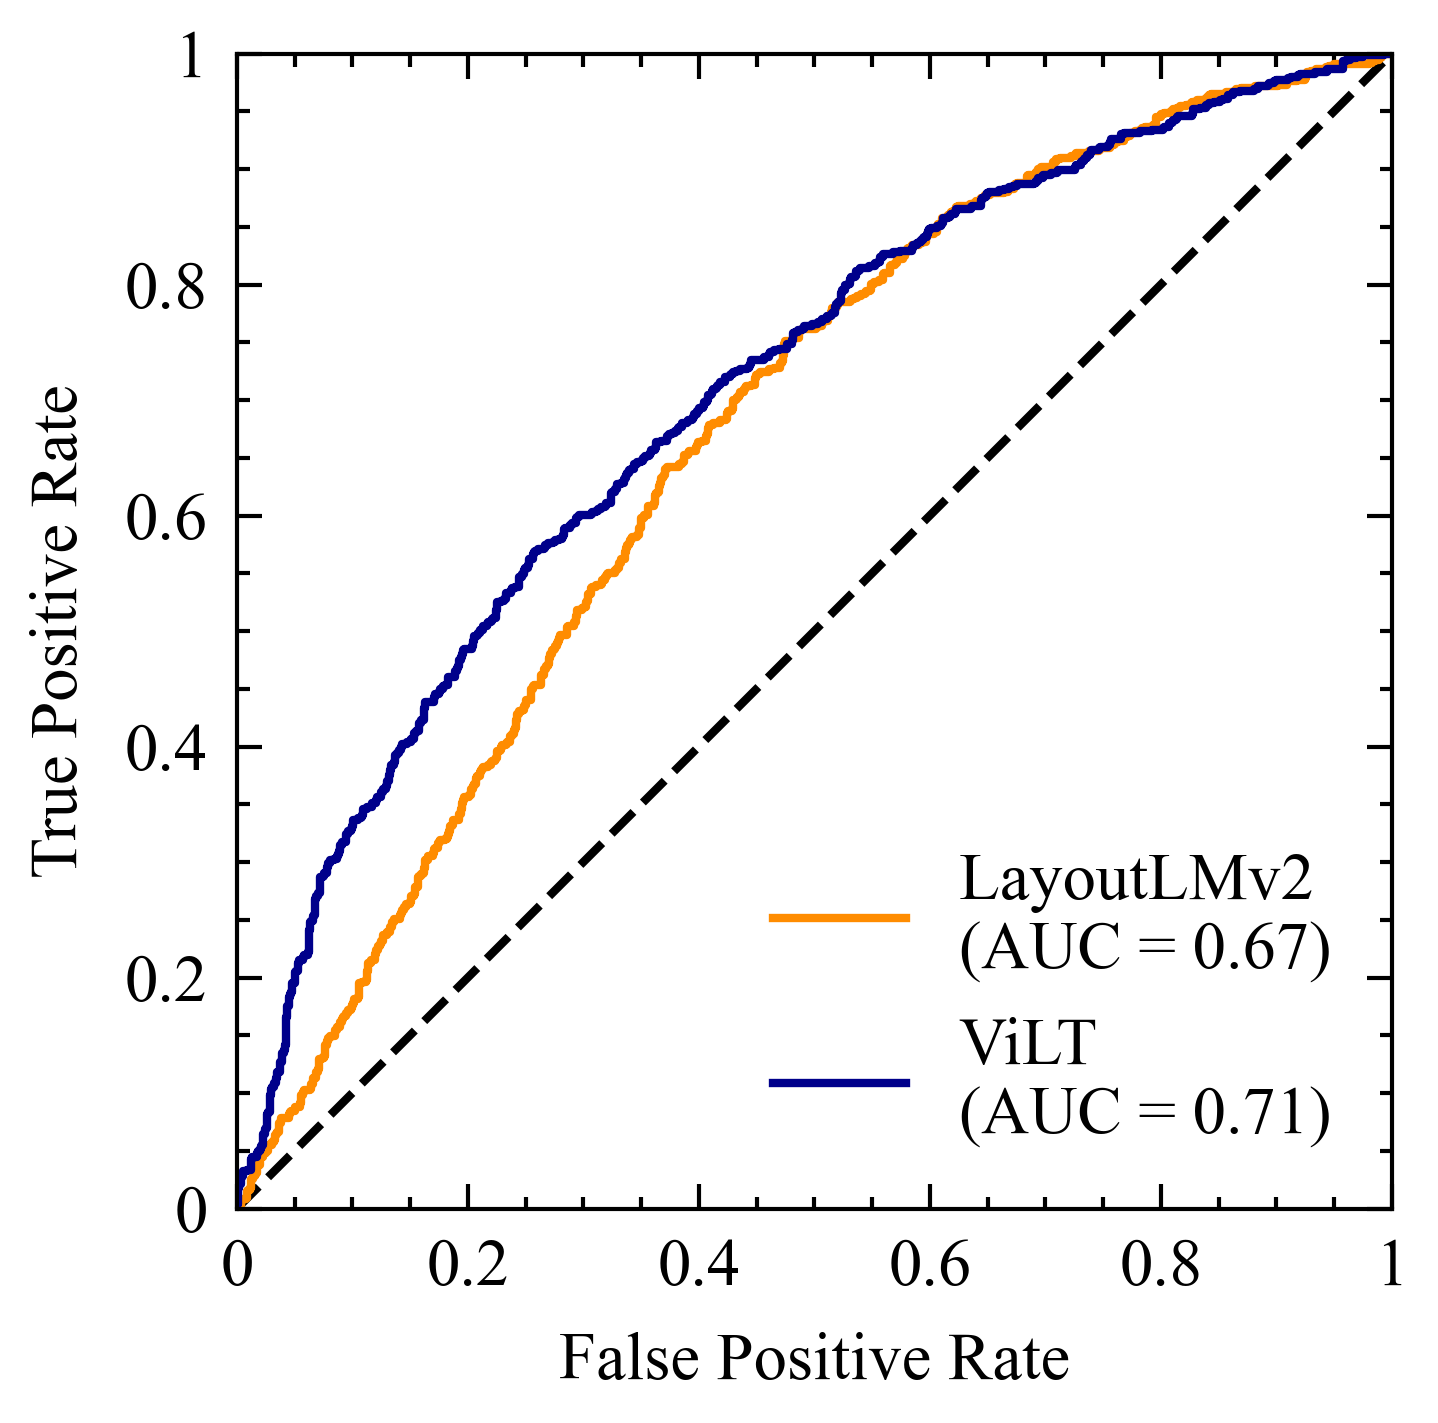

In [40]:
# create the figure
import latex
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

plt.style.use(['science','ieee', 'no-latex'])

plt.rcParams.update({
    "font.family": "serif",
    # Use LaTeX default serif font.
    "font.serif": ["Times New Roman"],
    # Use specific cursive fonts.
    "font.cursive": ["Comic Neue", "Times New Roman"],
})

# plot the roc curve
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], color='black', linestyle='--')

ax.plot(fpr_layout, tpr_layout, color='darkorange', label='LayoutLMv2 \n(AUC = %0.2f)' % auc(fpr_layout, tpr_layout))

ax.plot(fpr_vilt, tpr_vilt, color='darkblue', label='ViLT \n(AUC = %0.2f)' % auc(fpr_vilt, tpr_vilt), linestyle='-')

# remove the margin
ax.margins(0)

# set the axis labels and legend
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

# replace 0.0 with 0 and 1.0 with 1
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1'])

# make square
ax.set_aspect('equal')

ax.legend()
# save the figure
plt.savefig('roc_curve.pdf', bbox_inches='tight')